In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from jcopml.pipeline import num_pipe
from jcopml.utils import save_model
from jcopml.plot import plot_missing_value
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from luwiji.svm import illustration

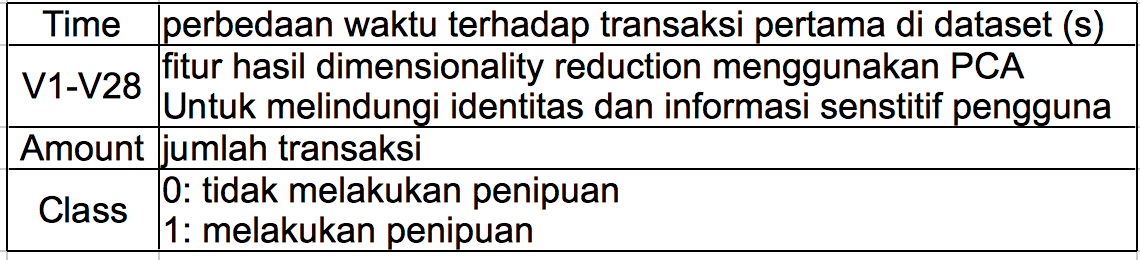

In [3]:
illustration.nomenklatur_cc_fraud

# Import CSV Data

In [4]:
df = pd.read_csv("data/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Cek Missing Value

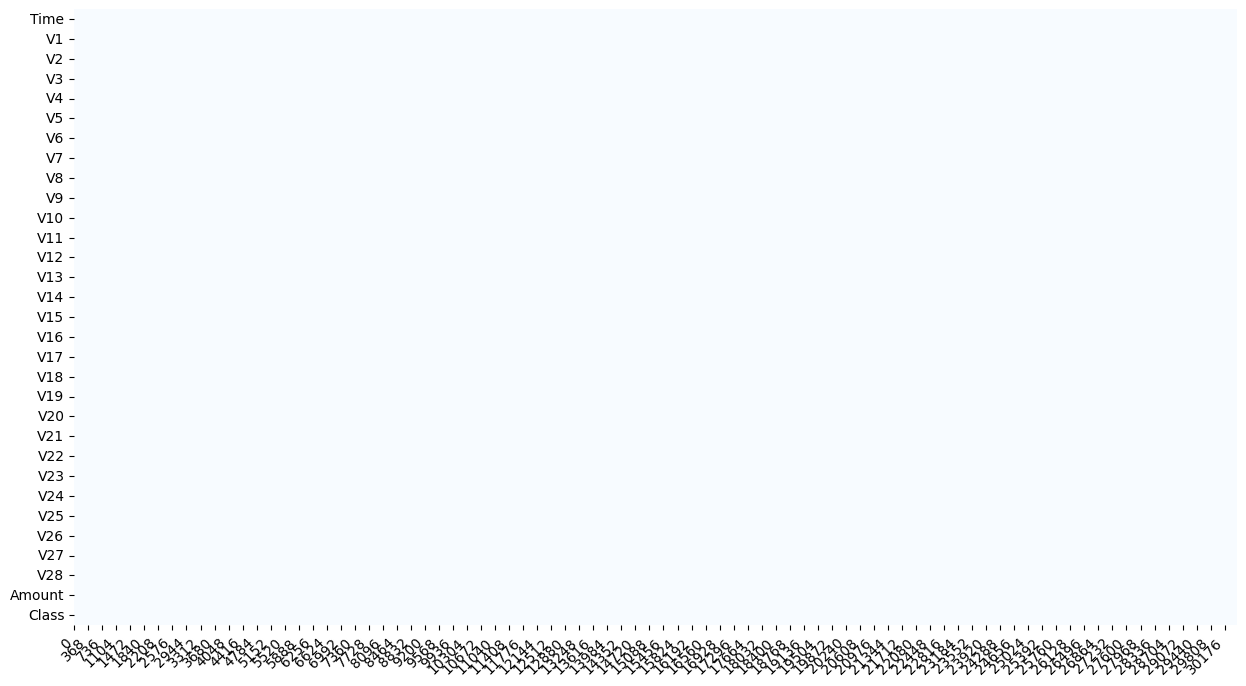

In [5]:
plot_missing_value(df)

# Dataset Splitting

In [6]:
X = df.drop(columns="Class")
y = df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24393, 30), (6099, 30), (24393,), (6099,))

# Pengecekan Dataset apakah balance atau imbalace

In [7]:
df.Class.value_counts()

Class
0    30000
1      492
Name: count, dtype: int64

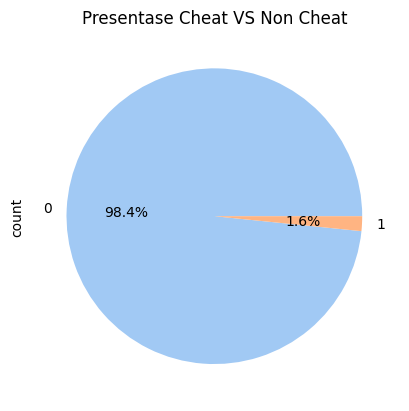

In [9]:
sns.set_palette('pastel')
df['Class'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Presentase Cheat VS Non Cheat')
plt.show()

# Training

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import BinaryAccuracy
from sklearn.metrics import f1_score

### Penggunaan ANN dengan hidden layer dan scoring f1

In [11]:
class ANNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_layers=(16, 8), activation='relu', optimizer='adam'):
        self.input_dim = input_dim
        self.activation = activation
        self.hidden_layers = hidden_layers
        self.optimizer = optimizer
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(units=self.input_dim, activation=self.activation))
        model.add(Dense(units=self.hidden_layers[0], activation=self.activation))
        model.add(Dense(units=self.hidden_layers[1], activation=self.activation))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=[BinaryAccuracy()])
        return model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=10, batch_size=32, verbose=0)
        self.classes_ = np.unique(y)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype(int)
    
    def predict_proba(self, X):
        return self.model.predict(X)

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='standard'), X_train.columns),
    ])

model = Pipeline([
    ('prep', preprocessor),
    ('algo', ANNClassifier(input_dim=len(X_train.columns)))
])

model.fit(X_train, y_train)

train_f1_score = f1_score(y_train, model.predict(X_train))
print("Train F1 Score:", train_f1_score)

test_f1_score = f1_score(y_test, model.predict(X_test))
print("Test F1 Score:", test_f1_score)

763/763 [==============================] - 1s 2ms/step
Train F1 Score: 0.9910828025477707
191/191 [==============================] - 0s 1ms/step
Test F1 Score: 0.9795918367346939


# Plot perbanding data asli Y_train dan hasil prediksi saat training

In [12]:
import matplotlib.pyplot as plt

763/763 [==============================] - 1s 1ms/step


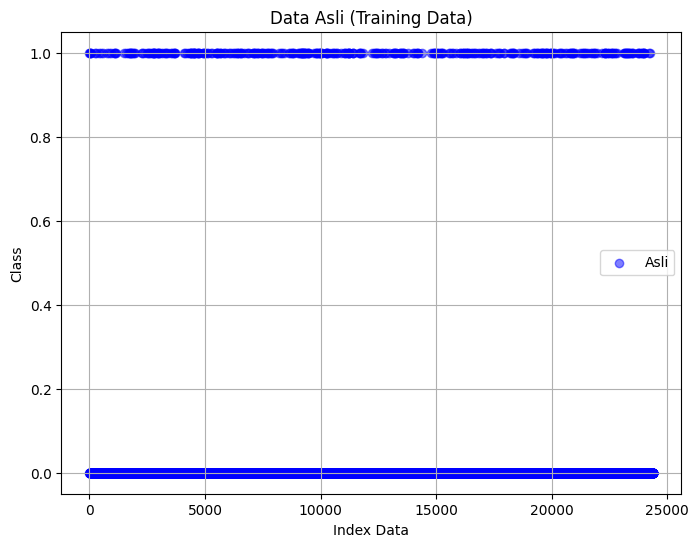

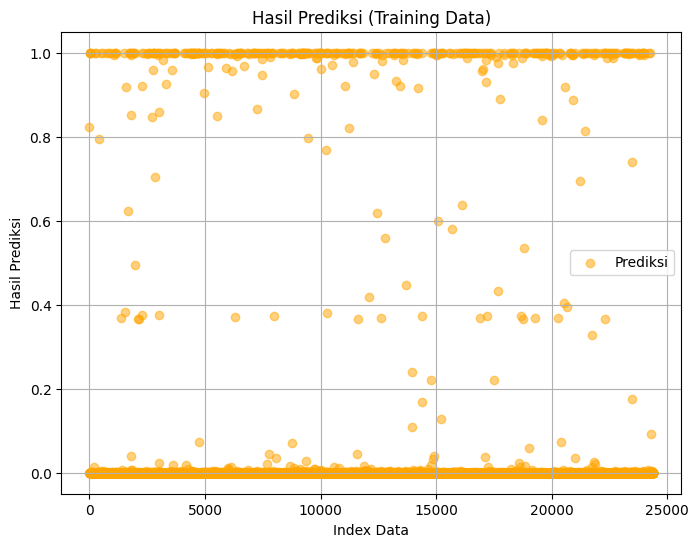

[[2.5383406e-04]
 [8.2274437e-01]
 [2.7580139e-08]
 ...
 [2.8963183e-07]
 [8.0882684e-10]
 [6.2264777e-13]]


In [13]:
# Mendapatkan prediksi untuk data training
y_train_pred = model.predict_proba(X_train)

# Plot untuk data actual training
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_train)), y_train, color='blue', label='Asli', alpha=0.5)
plt.title('Data Asli (Training Data)')
plt.xlabel('Index Data')
plt.ylabel('Class')
plt.legend()
plt.grid(True)
plt.show()

# Plot untuk data prediksi training
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_train_pred)), y_train_pred, color='orange', label='Prediksi', alpha=0.5)
plt.title('Hasil Prediksi (Training Data)')
plt.xlabel('Index Data')
plt.ylabel('Hasil Prediksi')
plt.legend()
plt.grid(True)
plt.show()

print(y_train_pred)


In [14]:
y_train_pred = (y_train_pred > 0.5).astype(int)

pred_counts = pd.Series(y_train_pred.flatten()).value_counts()

print("Jumlah Value untuk 0 dan 1 dalam hasil prediksi:")
print(pred_counts)

Jumlah Value untuk 0 dan 1 dalam hasil prediksi:
0    24002
1      391
Name: count, dtype: int64


# Hasil Perbandingan antara data test dan hasil prediksi dari data test

191/191 [==============================] - 0s 1ms/step


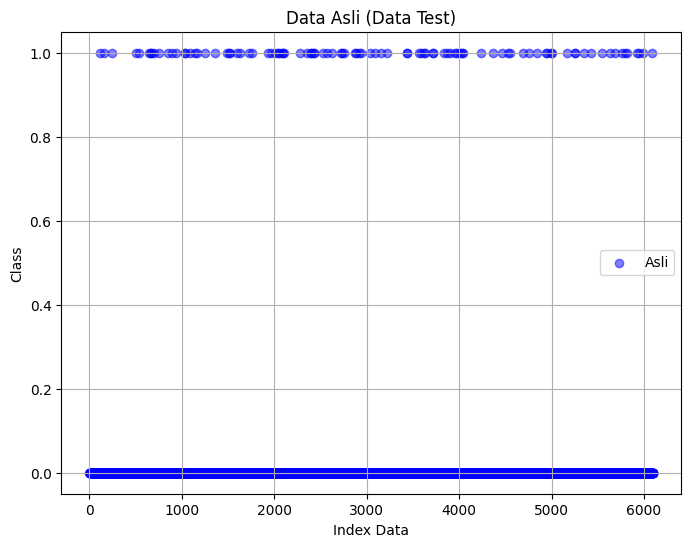

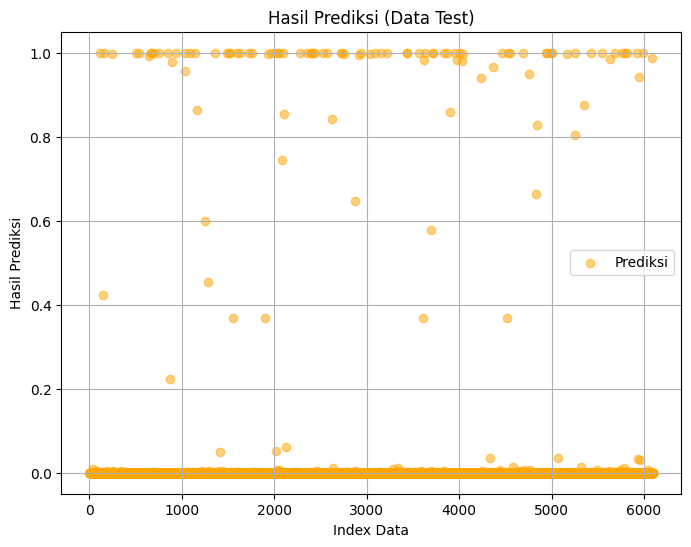

In [15]:
# Mendapatkan prediksi untuk data training
y_test_pred = model.predict_proba(X_test)

# Plot untuk data actual training
plt.figure(figsize=(8, 6))
plt.scatter(range(len(X_test)), y_test, color='blue', label='Asli', alpha=0.5)
plt.title('Data Asli (Data Test)')
plt.xlabel('Index Data')
plt.ylabel('Class')
plt.legend()
plt.grid(True)
plt.show()

# Plot untuk data prediksi training
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y_test_pred)), y_test_pred, color='orange', label='Prediksi', alpha=0.5)
plt.title('Hasil Prediksi (Data Test)')
plt.xlabel('Index Data')
plt.ylabel('Hasil Prediksi')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
y_test_pred = (y_test_pred > 0.5).astype(int)

pred_counts = pd.Series(y_test_pred.flatten()).value_counts()

print("Value Counts of Predicted Values:")
print(pred_counts)

Value Counts of Predicted Values:
0    6001
1      98
Name: count, dtype: int64
